# Training a Foreground Segmentation Tool with DINOv3

In this tutorial, we will train a linear foreground segmentation model using DINOv3 features.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

# Sette opp virtuel miljø 

## Hvis du har allerede en venv
- En mappe med navnet ".venv"(eller en annet navn som du selv har spesifisert) finnes i mappen din.
- Aktivere miljøet: 
    - CTRL + SHIFT + P 
    - Skriv følgende i feltet øverst på midten ">Python: Select Interpreter"
    - Velg det virtuelle miljøet som finnes. Står som oftest: Python 3.x.x (.venv) ...
- Lage ny venv
    - CTRL + SHIFT + P 
    - Skriv følgende i feltet øverst på midten ">Python: Select Interpreter"
    - Trykk "+ Create Virtual Environment"
    - Trykk deg videre og videre 


# Clone DINOv3

Clonet repoet til en valgfri mappe. 

- Repo: [https://github.com/facebookresearch/dinov3](https://github.com/facebookresearch/dinov3)


In [1]:
import os

# Sette miljøvariabler for DINOv3
# Dette bruker vi nedenfor for å finne nedlastede repoet: Du må skrive din egen sti her
os.environ["DINOV3_LOCATION"] = "/home/shahin/ai-research/AI-research-and-learning/models/computer vision/Meta DINOv3 /dinov3"


In [2]:
# Sjekke om miljøvariabelen er satt riktig

print("DINOV3_LOCATION:", os.getenv("DINOV3_LOCATION"))

DINOV3_LOCATION: /home/shahin/ai-research/AI-research-and-learning/models/computer vision/Meta DINOv3 /dinov3


In [3]:
# Laste ned alle pakkene som trengs: 
%pip install torch torchvision pillow numpy matplotlib scipy scikit-learn tqdm

# Eller kan man laste ned fra terminalen med "pip install -r requirements.txt" 

Note: you may need to restart the kernel to use updated packages.


In [4]:
#importere nødvendige biblioteker

import io
import os
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm

# Kommentere ut denne delen som setter DINOv3_LOCATION

# DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

# if os.getenv("DINOV3_LOCATION") is not None:
#     DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
# else:
#     DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

# print(f"DINOv3 location set to {DINOV3_LOCATION}")


In [5]:
# sett DINOv3 location til miljøvariabelen

DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")

if DINOV3_LOCATION is None:
    raise ValueError("DINOV3_LOCATION environment variabel er ikke satt. Se tidligere steg.")

print("DINOv3 location set to:", DINOV3_LOCATION)

DINOv3 location set to: /home/shahin/ai-research/AI-research-and-learning/models/computer vision/Meta DINOv3 /dinov3


### Model

Let's load the DINOv3 model. For this notebook, we will be using the ViT-L model, but if you have more or less hardware constraints, you can easily load any other DINOv3 model!

Du kan lese mere om modellen på [https://github.com/facebookresearch/dinov3](https://github.com/facebookresearch/dinov3).


# Laste ned "Weights" før vi laster inn modellen vi ønsker

- Gå til denne seksjonen på github: [https://github.com/facebookresearch/dinov3?tab=readme-ov-file#pretrained-models](https://github.com/facebookresearch/dinov3?tab=readme-ov-file#pretrained-models)
- Trykk på først modellen
- Fyll inn skjema informasjon, du får epost med link for å laste ned modellene
- Du trenger kun å laste ned denne modellen fra eposten: dinov3_vits16
- Lagre den et sted som du kan finne etterpå

# Vi laster inn modellen med koden nedenfor

**Trinn-for-trinn prosess:**

1. **Første kjøring (forventer feil):**
   - Koden nedenfor krever at vi har lagret "Weights" filen i: `~/.cache/torch/hub/checkpoints/`
   - Men denne mappen eksisterer ikke hvis vi ikke har lastet inn modeller med torch før
   - Vi kjører koden en gang - den vil feile fordi den ikke finner "Weights" enda, men den lager alle mappene

2. **Flytt weights-filen til riktig sted:**
   - Nå er mappene klare, du kan sjekke selv på `~/.cache/torch/hub/checkpoints/` (~ = Home/bruker_navn)
   - Flytt "weights" filen du lastet ned til `~/.cache/torch/hub/checkpoints/`

3. **Andre kjøring (skal fungere):**
   - Kjør koden på nytt, den vil laste inn modellen riktig denne gangen

In [6]:

# Vi starer med denne, da denne er minst og krever mindre ressurser
MODEL_DINOV3_VITS = "dinov3_vits16"

# Andre modeller du kan prøve
# Husk at du må laste ned "weights" for den modellen du ønsker å bruke
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-S (since we have the pretrained weights for this model)
MODEL_NAME = MODEL_DINOV3_VITS # Her kan du velge en annen modell 

# Load model without pretrained weights to avoid web download
model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local",
    pretrained=True 
)

# Set model to evaluation mode and move to GPU
model.eval()
model.cuda()

# Test the model with a small dummy input to see if it produces valid output
print("\nTesting model with dummy input...")
dummy_input = torch.randn(1, 3, 224, 224).cuda()
with torch.no_grad():
    try:
        test_output = model(dummy_input)
        print(f"Model test successful. Output shape: {test_output.shape}")
        print(f"Output has NaN: {torch.isnan(test_output).any()}")
        print(f"Output range: {test_output.min():.4f} to {test_output.max():.4f}")
    except Exception as e:
        print(f"Model test failed: {e}")
        print("There might be an issue with the model or checkpoint loading.")


Testing model with dummy input...
Model test successful. Output shape: torch.Size([1, 384])
Output has NaN: False
Output range: -1.9122 to 1.7444


### Data

- Vi laster inn bildene lokalt fra data mappen

**Orginale bilder:**
- images in `jpg` format:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz
```
- and segmentation masks stored as alpha channels in `png` files:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz
```

In total, there are 9 training image / mask pairs.


In [7]:

# Bruke bilder som er lagret lokalt på på "data" mappen
image_folder = "./data/foreground_segmentation_images"
label_folder = "./data/foreground_segmentation_labels"

def load_images_from_folder(folder: str) -> list[Image.Image]:
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(folder, filename))
            images.append(img)
            print(f"Loaded {filename} from {folder}")

    print(f"Total images loaded from {folder}: {len(images)}\n")
    return images

images = load_images_from_folder(image_folder)
labels = load_images_from_folder(label_folder)
n_images = len(images)

assert n_images == len(labels), f"{len(images)=}, {len(labels)=}" # Sjekke at vi har like mange bilder og labels

print(f"Loaded {n_images} images and labels from local folders")




Loaded image_01.jpg from ./data/foreground_segmentation_images
Loaded image_02.jpg from ./data/foreground_segmentation_images
Loaded image_03.jpg from ./data/foreground_segmentation_images
Loaded image_04.jpg from ./data/foreground_segmentation_images
Loaded image_05.jpg from ./data/foreground_segmentation_images
Loaded image_06.jpg from ./data/foreground_segmentation_images
Loaded image_07.jpg from ./data/foreground_segmentation_images
Loaded image_08.jpg from ./data/foreground_segmentation_images
Loaded image_09.jpg from ./data/foreground_segmentation_images
Total images loaded from ./data/foreground_segmentation_images: 9

Loaded label_01.png from ./data/foreground_segmentation_labels
Loaded label_02.png from ./data/foreground_segmentation_labels
Loaded label_03.png from ./data/foreground_segmentation_labels
Loaded label_04.png from ./data/foreground_segmentation_labels
Loaded label_05.png from ./data/foreground_segmentation_labels
Loaded label_06.png from ./data/foreground_segmenta

Let's, for example, visualize the first image / mask pair:

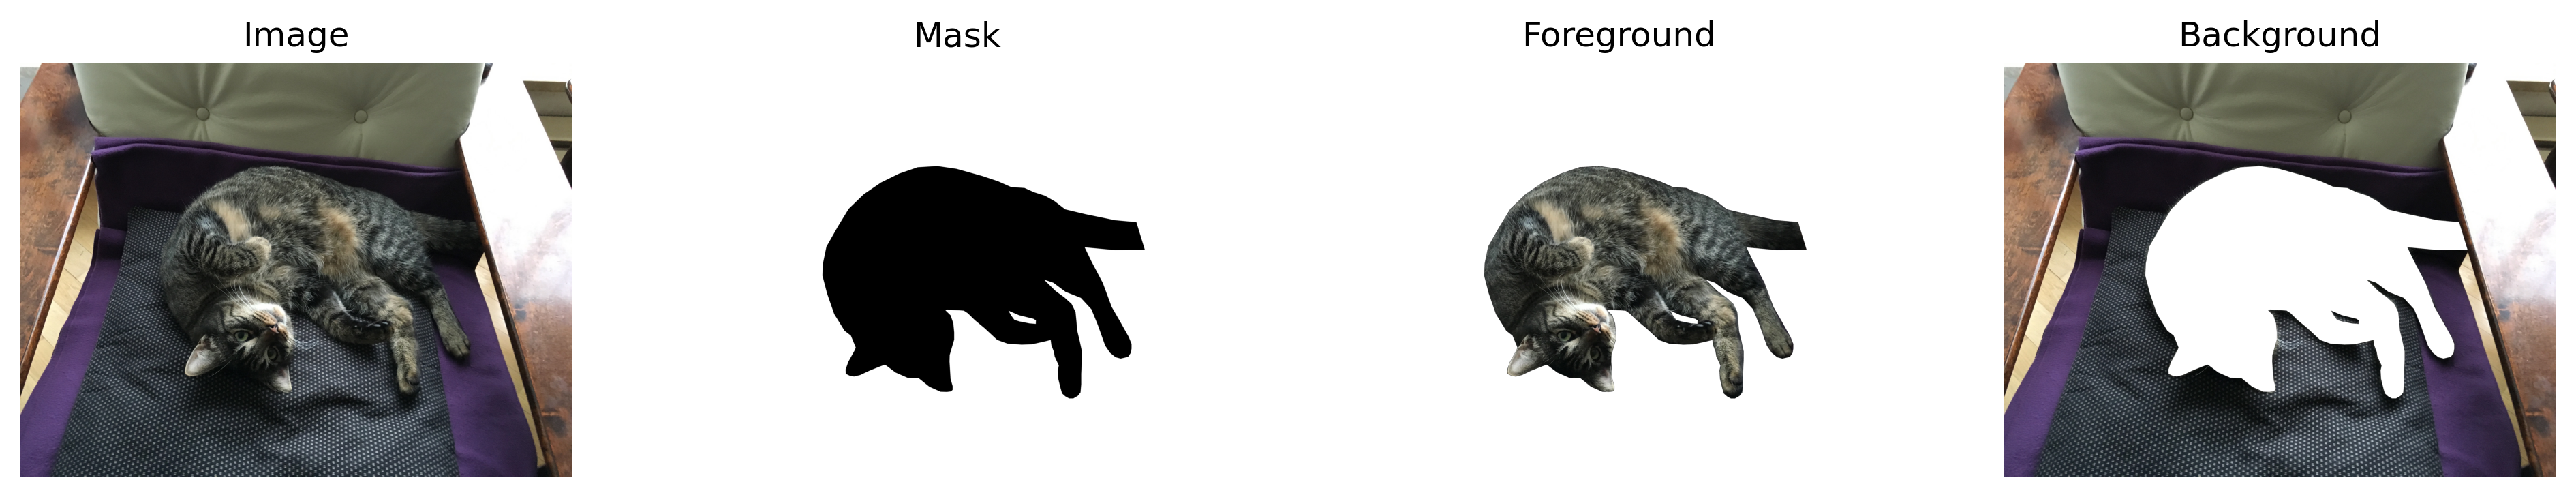

[[[253 255 252]
  [253 255 252]
  [253 255 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 255 252]
  [253 255 252]
  [253 255 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 255 252]
  [253 255 252]
  [253 255 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 70  55  98]
  [ 71  56  99]
  [ 72  57 100]
  ...
  [105  76  62]
  [ 99  70  56]
  [ 94  65  51]]

 [[ 70  57 100]
  [ 71  58 101]
  [ 72  59 102]
  ...
  [104  75  61]
  [ 97  68  54]
  [ 95  66  52]]

 [[ 66  53  96]
  [ 67  54  97]
  [ 69  56  99]
  ...
  [100  71  57]
  [ 96  67  53]
  [ 97  68  54]]]


In [8]:

def show_images(amount):
    for image, mask in zip(images[:amount], labels[:amount]):
        foreground = Image.composite(image, mask, mask)
        mask_bg_np = np.copy(np.array(mask))
        mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
        mask_bg = Image.fromarray(mask_bg_np)
        background = Image.composite(image, mask_bg, mask_bg)

        data_to_show = [image, mask, foreground, background]
        data_labels = ["Image", "Mask", "Foreground", "Background"]

        plt.figure(figsize=(16, 4), dpi=300)
        
        for i in range(len(data_to_show)):
            plt.subplot(1, len(data_to_show), i + 1)
            plt.imshow(data_to_show[i])
            plt.axis('off')
            plt.title(data_labels[i], fontsize=12)
        plt.show()

vise_antall_bilder = 1
show_images(vise_antall_bilder)

# printe ut et bilde som en numpy array
print(np.array(images[0]))

# Oppgave

Oppgavene ligger i [./oppgaver.ipynb](./oppgaver.ipynb)

---

# Vision Transformer (ViT)

- **Patch + position Embeddings**: Bildet deles opp i små patches som gjøres om til vektorer (embeddings). Posisjonskoder legges til for å bevare hvor i bildet patchene hører hjemme.  

- **Transformer Encoder**: En sekvensmodell som bruker self-attention til å finne sammenhenger mellom alle patches og bygger opp en helhetsforståelse av bildet.  

- **MLP (Multi-Layer Perceptron)**: Et lite nevralt nettverk som oversetter de bearbeidede representasjonene til en mer kompakt form som kan brukes til klassifisering.  

- **Class**: Et eget token ([CLS]) brukes til å samle informasjon fra hele bildet. Denne sendes videre til en klassifikator som kan trenes på brukerdefinerte kategorier eller merker.  


![image.png](https://raw.githubusercontent.com/RobvanGastel/dinov3-finetune/d109d85a45ab9c03de369f65db5bbd3da5cb77c7/assets/examples/vit.png)

### Building Per-Patch Label Map

Since our models run with a patch size of 16, we have to quantize the ground truth to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

### Patch-basert prosessering i Vision Transformers
**Hvorfor trenger vi denne koden?**

Vision Transformers (ViT) deler bilder inn i 16×16 piksler store "patches" (firkanter). Men våre treningsbilder og masker kan ha hvilken som helst størrelse. Vi må derfor:

- Endre størrelse på bildene så de passer med 16×16 rutenett
- Kvantisere maskene til samme rutenett

In [9]:
# Konstanter for patch-størrelse og bilde-størrelse

PATCH_SIZE = 16    # Hver patch er 16×16 piksler
IMAGE_SIZE = 768   # Standard høyde vi skalerer til (768÷16 = 48 patches høyt)

**Hvorfor 768?**
- 768 ÷ 16 = 48 patches
- Vanlig størrelse for ViT modeller
- Balanse mellom kvalitet og hastighet

### Kvantiseringsfilter
**Hva gjør dette?**

Dette lager et **gjennomsnittsfilter** som:

- Tar gjennomsnittet av alle piksler i hver 16×16 patch
- Reduserer oppløsningen fra piksel-nivå til patch-nivå

In [10]:
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE)) # Fyller data med 1/(16*16)= 0.00390625


tensor([[[[0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
           0.0039, 

### Resize Transform

**Hvorfor er dette viktig?**

Før prosessering:
- Bildet kan være 1200×800, 1920×1080, eller hvilken som helst størrelse
- Kan ikke brukes direkte med ViT (krever patch-struktur)

Etter prosessering:
- Bildet er eksakt delelig med 16×16 patches
-  Masken har samme oppløsning som ViT's feature maps
-  Hver patch har en label (forgrunn/bakgrunn)

In [11]:
# Denne funksjonen bruker vi videre for å endre størrelse på maskene slik at de passer med patch-størrelsen
def resize_transform(mask_image: Image, image_size: int = IMAGE_SIZE, patch_size: int = PATCH_SIZE) -> torch.Tensor:
    w, h = mask_image.size                              # Original størrelse
    h_patches = int(image_size / patch_size)            # Antall patches vertikalt (768÷16=48)
    w_patches = int((w * image_size) / (h * patch_size)) # Antall patches horisontalt
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

Let's, for example, visualize the first mask before and after quantization:

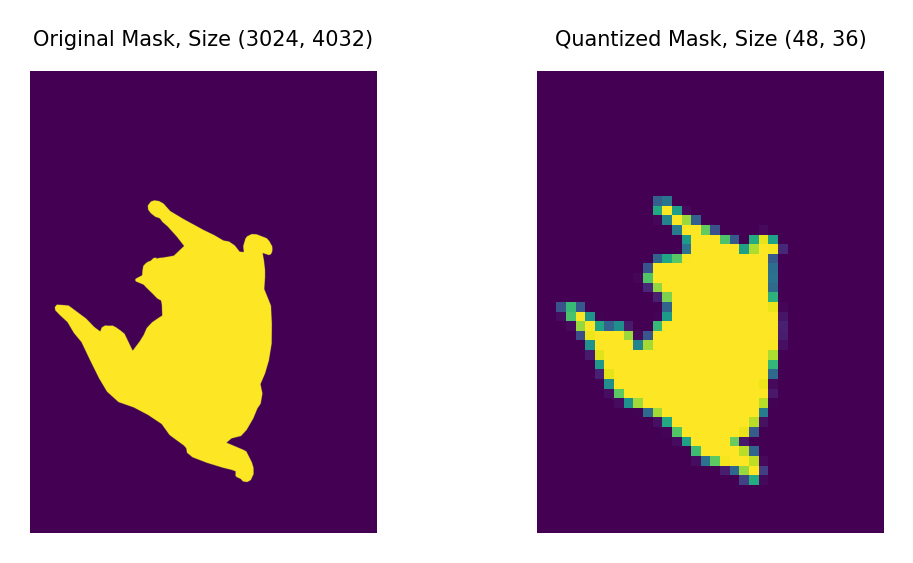

In [12]:
# Her henter vi en maske og viser original og kvantisert maske
# Vi splitter masken i ulike kanaler (RGBA) og bruker bare alpha-kanalen som er siste kanal
mask_0 = labels[1].split()[-1] 
mask_0_resized = resize_transform(mask_0)

with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

## Patch Grid Visualisering

Nedenfor illustrerer hvordan et bilde ser ut etter kvantifisering.

### **Hva den gjør:**
- **Viser original maske** som gråtonebilde
- **Tegner røde ruter** for hver 16×16 patch 
- **Skriver forgrunn-andel** i hver patch (hviser kun hvis > 0)
- **Formatter tall** for bedre lesbarhet (.5 i stedet for 0.5)

### **Visuelt resultat:**
```
┌─────┬─────┬─────┐
│  .2 │  .8 │     │  ← Patch-verdier
├─────┼─────┼─────┤     (.2 = 20% forgrunn)
│  1  │  .9 │  .1 │
├─────┼─────┼─────┤
│     │  .7 │     │
└─────┴─────┴─────┘
```


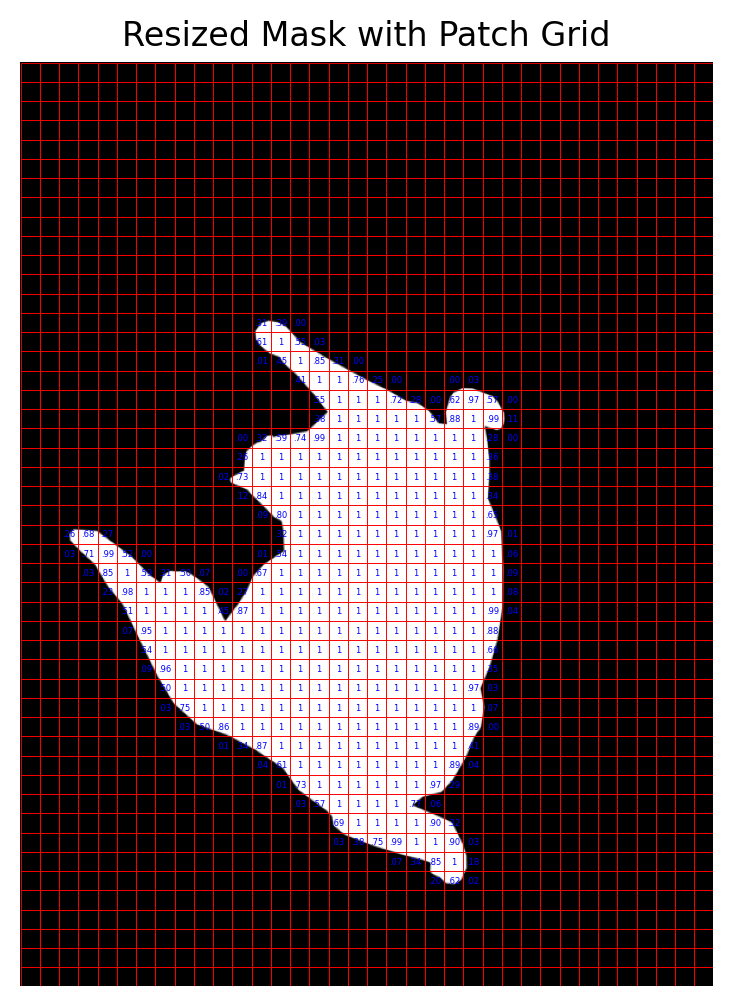

In [13]:
import matplotlib.patches as patches

# Plot with grid overlay
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(mask_0_resized.squeeze().numpy(), cmap="gray")
plt.axis("off")
plt.title("Resized Mask with Patch Grid")

h, w = mask_0_resized.shape[1:]
for y in range(0, h, PATCH_SIZE):
    for x in range(0, w, PATCH_SIZE):
        rect = patches.Rectangle((x, y), PATCH_SIZE, PATCH_SIZE,
                                 linewidth=0.3, edgecolor="red", facecolor="none")

        # Prosentandel av "foreground" i denne patchen        
        foreground_present = mask_0_quantized[y // PATCH_SIZE, x // PATCH_SIZE]

        # Vise bare tekst hvis det er noe "foreground" i patchen
        if foreground_present != 0:
            rect_text = f"{foreground_present:.2f}" # Tar med to desimaler
            
            # Formatere teksten for å unngå store tall som 0.07 eller 1.00 etc.
            # Splitter teksten ved desimalpunktet, vi får tilbake en liste med to elementer for eksempel 0.07 --> ["0", "07"]
            rect_text_split = rect_text.split(".")
            if rect_text_split[0] == "0":
                rect_text = f".{rect_text_split[1]}"
            elif rect_text_split[0] == "1":
                rect_text = f"{rect_text_split[0]}"
            else:
                rect_text = f"{rect_text_split[0]}.{rect_text_split[1]}"

            plt.text(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, rect_text,
                    color="blue", fontsize=3, ha="center", va="center")
        plt.gca().add_patch(rect)


plt.show()

### Extracting Features and Labels for All the Images
Now we will loop over the 9 training images, and extract for each image the patch labels, as well as the patch features. That involves running the dense feature extraction of our model with :

```
with torch.no_grad():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    dim = feats[-1].shape[1]
    xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
```

- xs -> Liste over "features"
- ys -> liste over "labels" (foreground = 1, bakground = 0, per patch)
- image_index -> holder orden hvilket del av bilde en patch tilhører. 
    - Når vi deler opp bilde i patcher (de røde rectanglene i forige bilde)
    - Hvert patch (rectangel) får en indeks for å holde orden på hvor på bilde en batch tilhører

In [14]:
# Vi kan printe litt informasjon om modellen
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

Processing images:   0%|          | 0/9 [00:00<?, ?it/s]

Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-0.5942, -0.5502, -0.4178,  ..., -0.4231, -0.5081, -0.3966],
          [-0.6377, -0.5843, -0.5157,  ..., -0.4674, -0.5115, -0.5575],
          [-0.7551, -0.4865, -0.4535,  ..., -0.3290, -0.3597, -0.3125],
          ...,
          [-0.0667,  0.0391,  0.0130,  ..., -0.0990, -0.2030, -0.2099],
          [-0.1791,  0.0662,  0.2020,  ..., -0.0157, -0.1760, -0.1719],
          [-0.1412,  0.0402,  0.1997,  ...,  0.0146, -0.1446, -0.1382]],

         [[-0.1742, -0.1773, -0.2119,  ..., -0.0898, -0.0345, -0.0277],
          [-0.1836, -0.2118, -0.1621,  ..., -0.0905, -0.0486, -0.0436],
          [-0.1716, -0.1597, -0.1517,  ..., -0.1723, -0.1492, -0.0511],
          ...,
          [-0.2811, -0.3330, -0.3428,  ..., -0.4663, -0.4479, -0.3946],
          [-0.2645, -0.3259, -0.3445,  ..., -0.5041, -0.4732, -0.4236],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


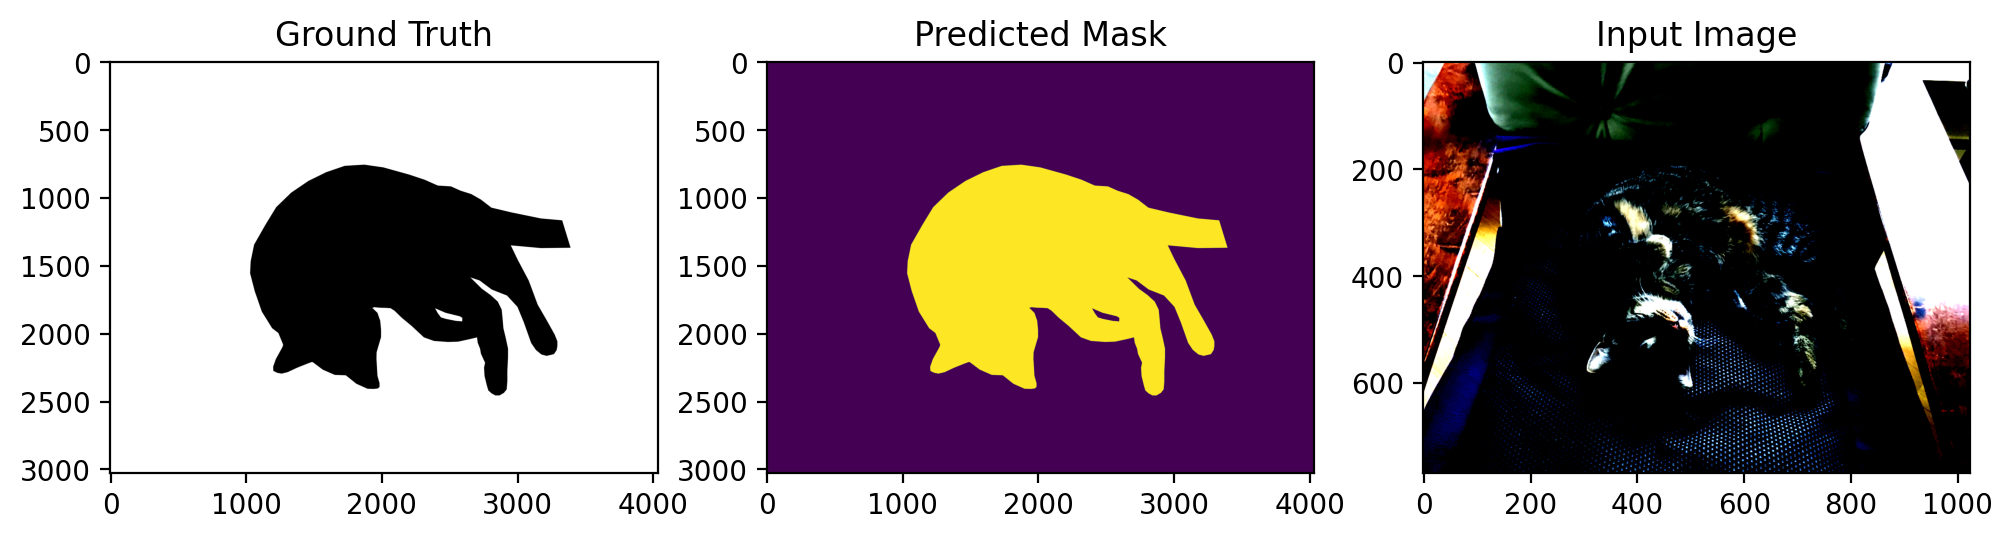

Processing images:  11%|█         | 1/9 [00:10<01:23, 10.45s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 36])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 36])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


feature fra siste lag: tensor([[[[-0.2947, -0.4347, -0.0614,  ..., -0.1287, -0.2230,  0.1280],
          [-0.4921, -0.1239,  0.0026,  ..., -0.3927, -0.2705, -0.1047],
          [-0.5170, -0.1194,  0.0496,  ..., -0.1260, -0.3129, -0.3819],
          ...,
          [ 0.2844,  0.3303,  0.3552,  ...,  0.0278, -0.0569, -0.1744],
          [ 0.1802,  0.1838,  0.1904,  ..., -0.1480,  0.0462,  0.0984],
          [-0.1173,  0.0644, -0.0261,  ...,  0.2796,  0.2120,  0.0378]],

         [[ 0.3055,  0.1783,  0.1194,  ..., -0.0108, -0.0032,  0.0034],
          [ 0.3569,  0.1099,  0.0499,  ...,  0.0446,  0.1096,  0.0610],
          [ 0.3374,  0.0829,  0.0135,  ...,  0.0379,  0.0961,  0.0954],
          ...,
          [ 0.3090,  0.2630,  0.2497,  ..., -0.0251, -0.0533, -0.0348],
          [ 0.2538,  0.2202,  0.2134,  ..., -0.0178, -0.1569, -0.1201],
          [ 0.1903,  0.1992,  0.1895,  ..., -0.3665, -0.3230, -0.1646]],

         [[ 0.3606, -0.2397, -0.2838,  ...,  0.3685,  0.2743,  0.0625],
       

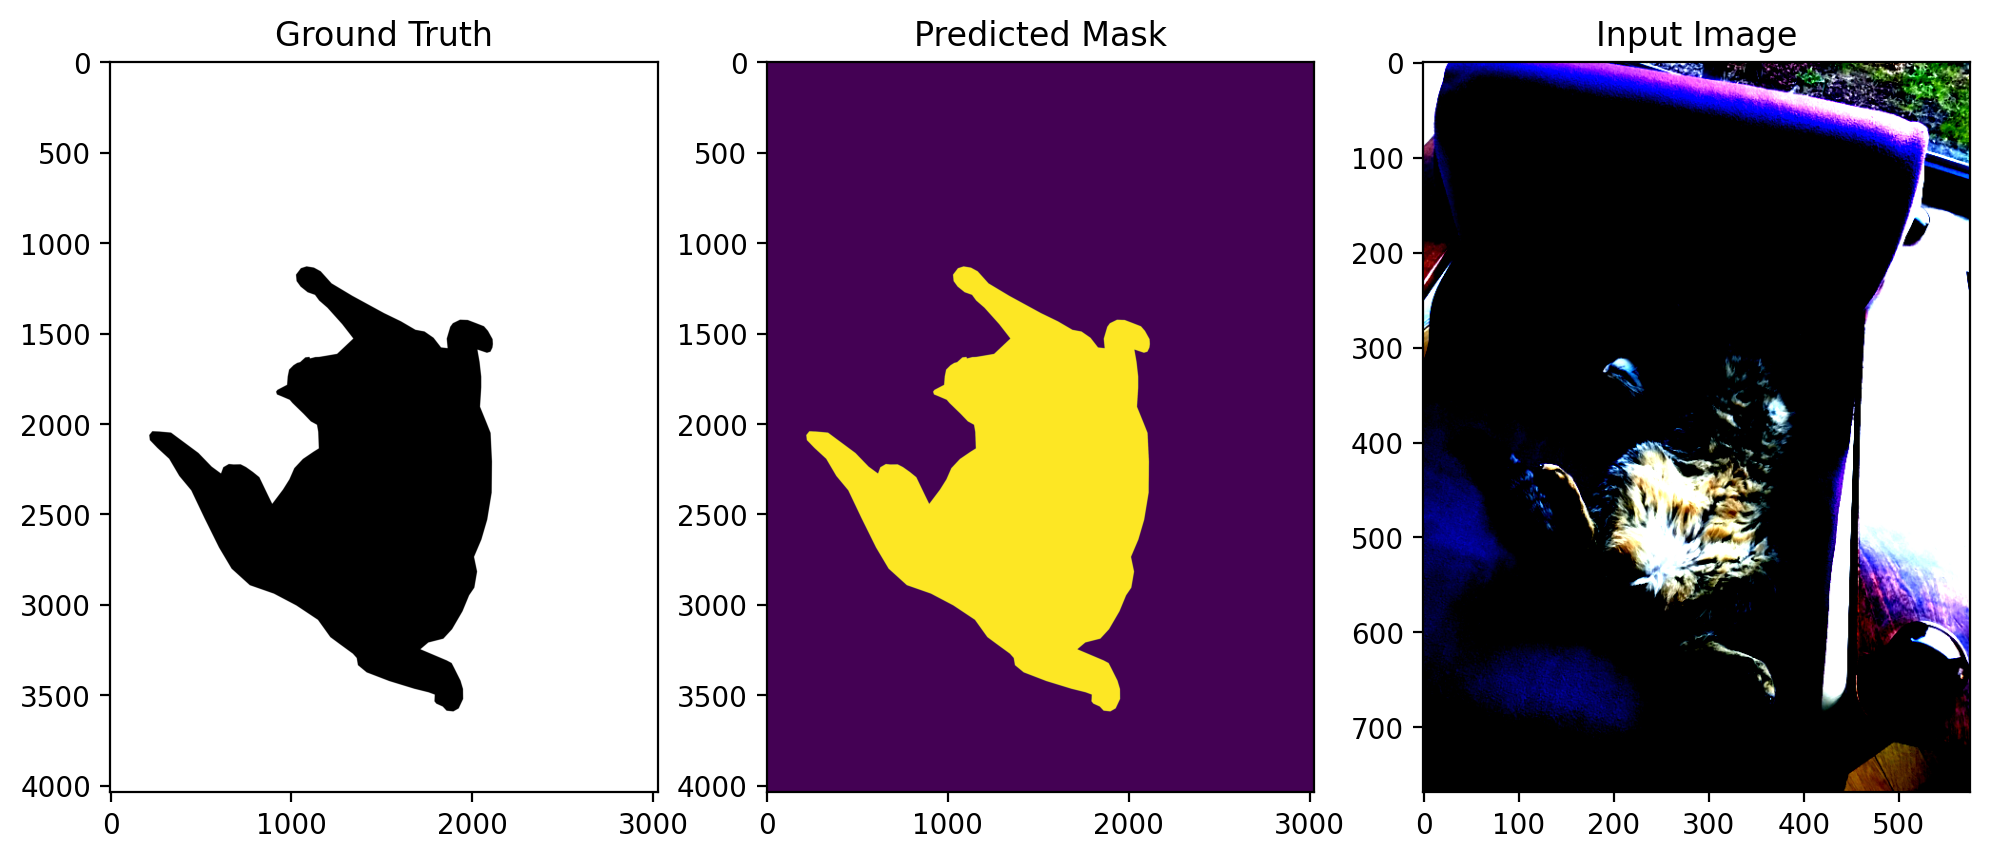

Processing images:  22%|██▏       | 2/9 [00:15<00:50,  7.22s/it]

torch.Size([1728, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-0.2863, -0.2130, -0.1752,  ..., -0.4100, -0.2673, -0.1439],
          [-0.2374, -0.3263, -0.1121,  ..., -0.4257, -0.4165, -0.1988],
          [-0.3806, -0.2075, -0.2526,  ..., -0.4359, -0.4889, -0.2832],
          ...,
          [-0.2511, -0.1701, -0.0111,  ...,  0.2152,  0.2139,  0.3634],
          [-0.1733,  0.0211, -0.1487,  ...,  0.3269,  0.1347,  0.2153],
          [-0.0905,  0.0734, -0.1395,  ...,  0.2079,  0.1953,  0.3183]],

         [[ 0.0843,  0.0242,  0.0631,  ...,  0.0840,  0.0344,  0.0456],
          [ 0.0661,  0.1449,  0.0668,  ...,  0.1016,  0.1006,  0.1007],
          [ 0.1832,  0.1072,  0.1095,  ...,  0.1085,  0.1339,  0.1045],
          ...,
          [ 0.2613,  0.2394,  0.2084,  ..., -0.2147, -0.2081, -0.2075],
          [ 0.2235,  0.1918,  0.2488,  ..., -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


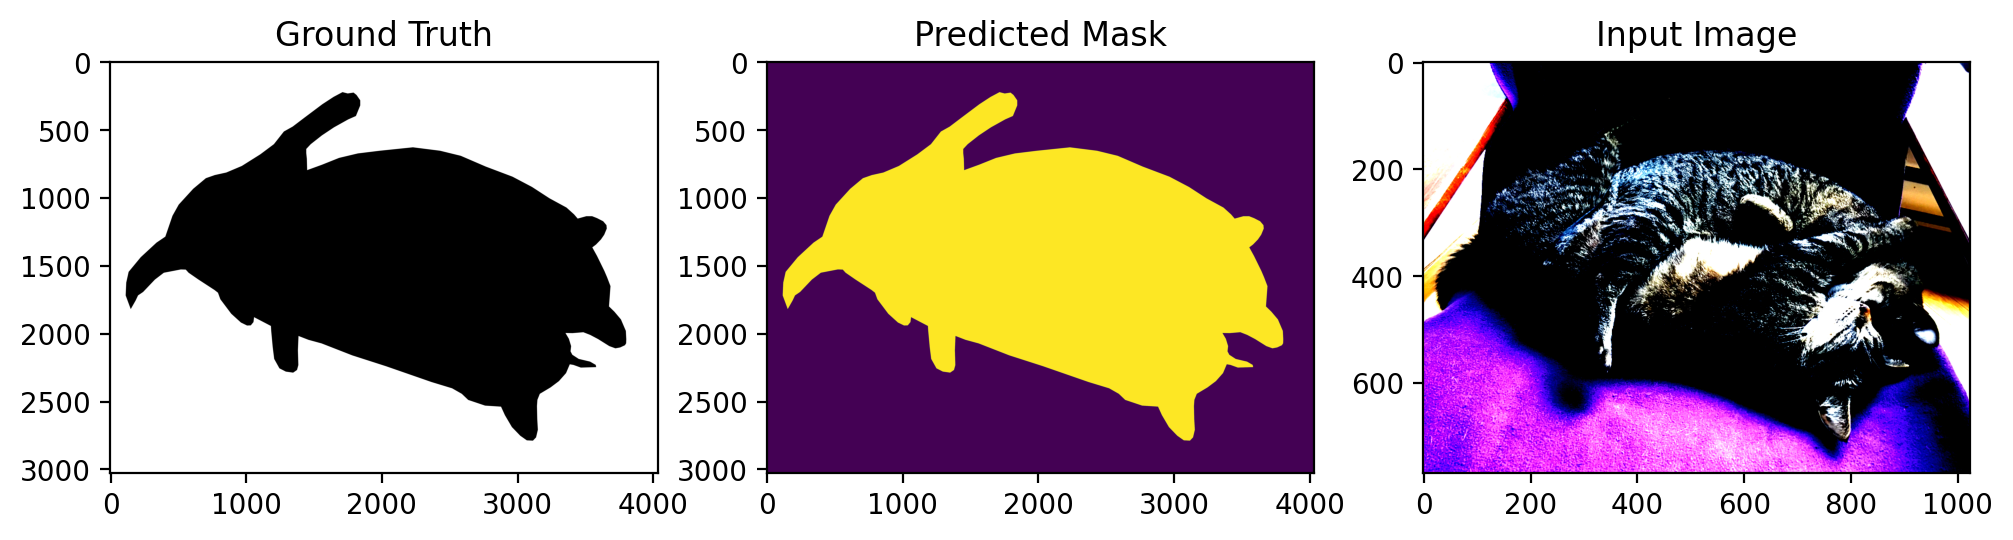

Processing images:  33%|███▎      | 3/9 [00:22<00:42,  7.08s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-0.6981, -0.5681, -0.5488,  ..., -0.7976, -0.9583, -0.8812],
          [-0.5665, -0.4903, -0.5015,  ..., -0.8855, -0.9191, -0.9477],
          [-0.7195, -0.6419, -0.6548,  ..., -0.8579, -0.8679, -0.9278],
          ...,
          [-0.2156, -0.0898, -0.0573,  ..., -0.1363, -0.2682, -0.2032],
          [-0.0063, -0.0119, -0.0474,  ..., -0.1975, -0.3412, -0.1810],
          [-0.0330, -0.0812,  0.0773,  ..., -0.1861, -0.1581, -0.1202]],

         [[ 0.1662,  0.1194,  0.1671,  ...,  0.1277,  0.2114,  0.2282],
          [ 0.2250,  0.2404,  0.2351,  ...,  0.1617,  0.1951,  0.2309],
          [ 0.2868,  0.2898,  0.2760,  ...,  0.1845,  0.2055,  0.2264],
          ...,
          [ 0.2030,  0.1545,  0.1508,  ...,  0.2896,  0.3366,  0.3557],
          [ 0.1270,  0.1782,  0.1377,  ...,  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.4308496].


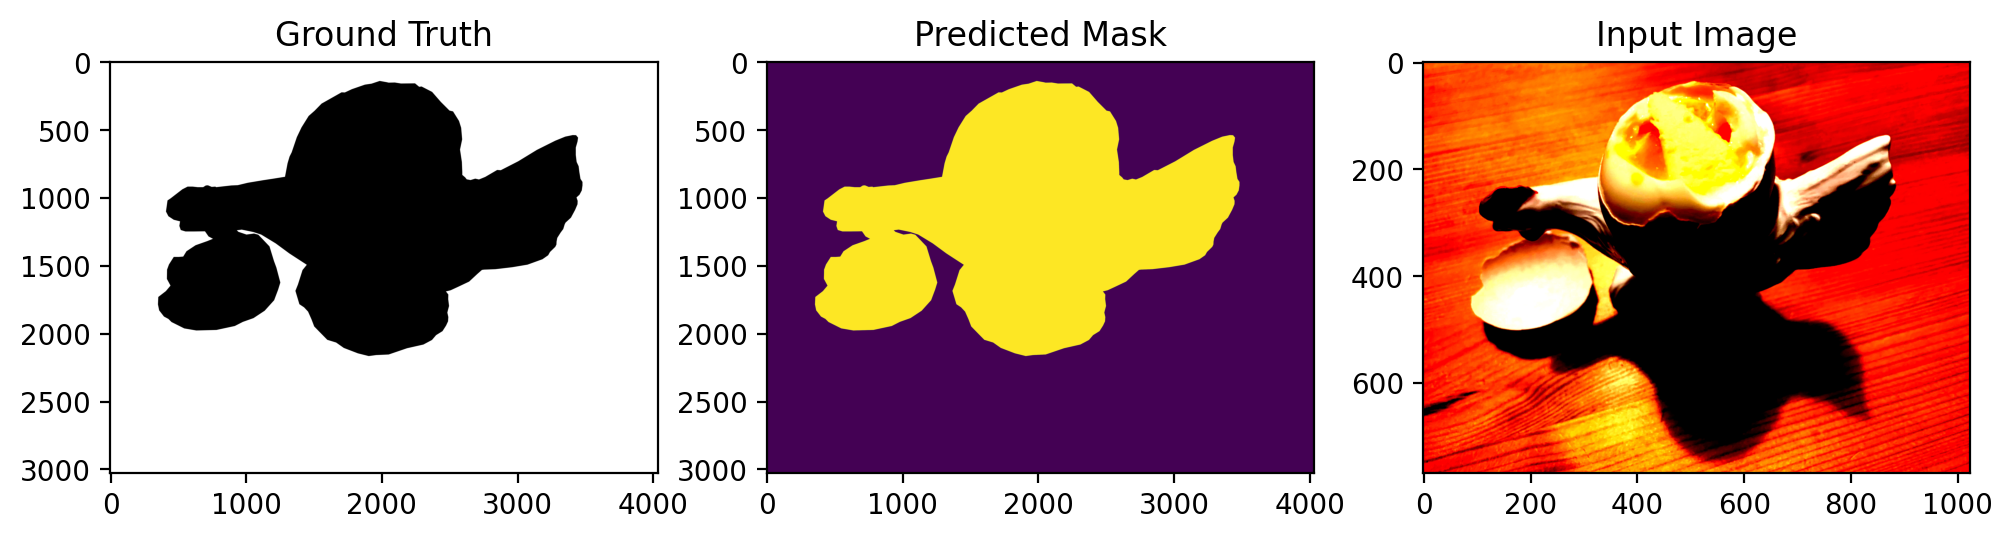

Processing images:  44%|████▍     | 4/9 [00:29<00:36,  7.22s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-0.4639, -0.4978, -0.4997,  ..., -0.4402, -0.4171, -0.3042],
          [-0.4804, -0.5160, -0.4913,  ..., -0.2416, -0.4027, -0.5560],
          [-0.5172, -0.4477, -0.4366,  ..., -0.2859, -0.3648, -0.2536],
          ...,
          [-0.0516,  0.0216, -0.1716,  ...,  0.1019,  0.1285,  0.0390],
          [ 0.0035,  0.0015, -0.1775,  ...,  0.1354, -0.0692,  0.0939],
          [ 0.0635, -0.0571,  0.0321,  ...,  0.0341,  0.0375,  0.2370]],

         [[-0.0589, -0.0500, -0.0081,  ..., -0.0705,  0.0086, -0.0038],
          [-0.0734,  0.0105,  0.0440,  ...,  0.0128,  0.0176,  0.0086],
          [-0.0080,  0.0225,  0.0296,  ...,  0.0924,  0.0577,  0.0433],
          ...,
          [-0.0057, -0.0565,  0.0138,  ...,  0.1181,  0.1265,  0.1903],
          [-0.1119, -0.0914, -0.1389,  ...,  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


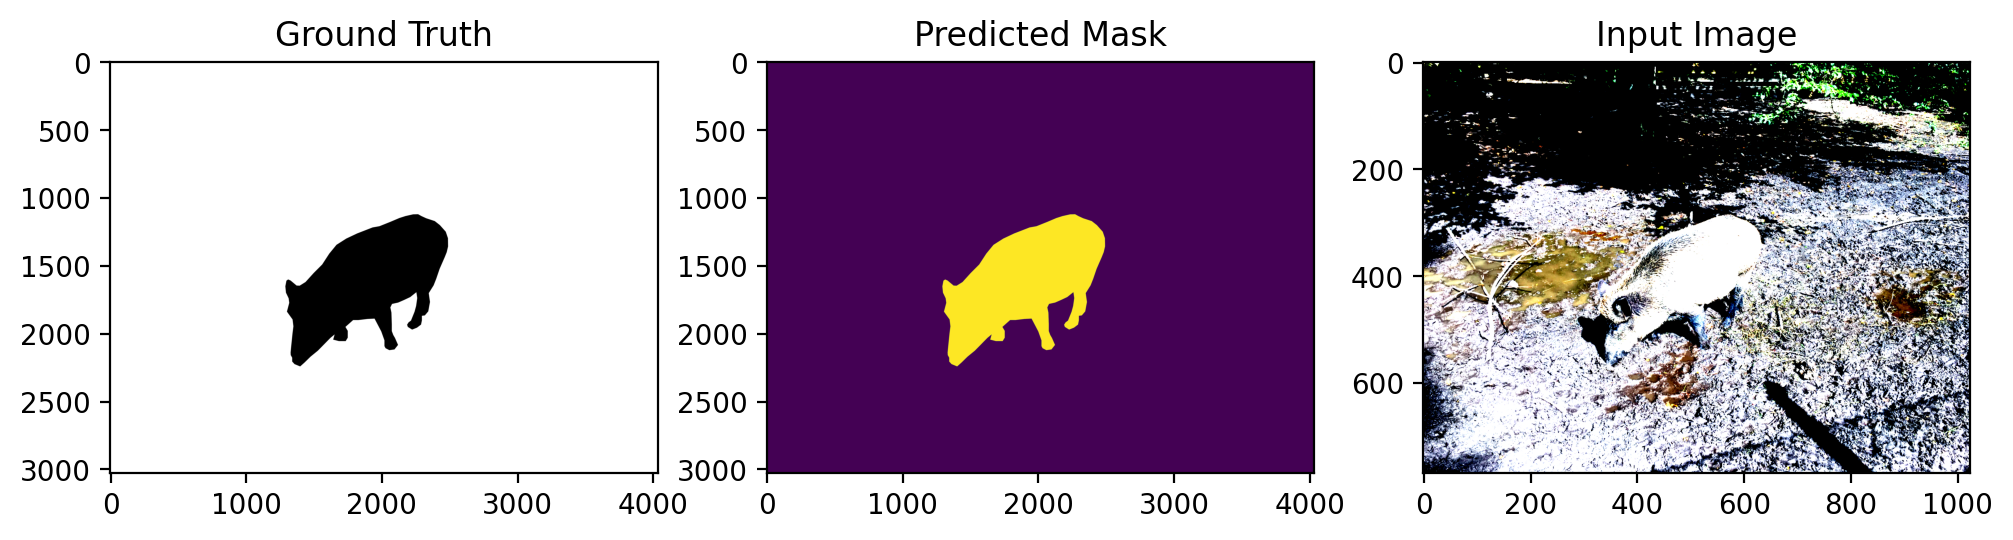

Processing images:  56%|█████▌    | 5/9 [00:37<00:29,  7.43s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-6.1243e-01, -5.7843e-01, -5.4217e-01,  ..., -1.1625e-01,
           -1.5960e-01, -3.1497e-01],
          [-6.6231e-01, -6.5698e-01, -6.1394e-01,  ..., -2.2577e-01,
           -1.3023e-01, -2.6123e-01],
          [-7.4563e-01, -7.1455e-01, -6.3582e-01,  ..., -2.5021e-01,
           -1.6875e-01, -1.7677e-01],
          ...,
          [-7.5226e-02,  1.1056e-01,  1.9150e-01,  ..., -1.9798e-01,
           -2.4059e-02, -2.5541e-01],
          [ 5.0517e-02,  7.7652e-02,  2.6434e-01,  ...,  5.4523e-02,
            6.5331e-02,  7.6453e-02],
          [ 1.2202e-01,  2.5060e-01,  1.8420e-01,  ...,  6.0157e-02,
            4.5859e-02, -2.2076e-02]],

         [[ 1.9491e-01,  2.4676e-01,  2.0328e-01,  ...,  4.2842e-01,
            2.9894e-01,  3.2903e-01],
          [ 2.1928e-01,  2.8422e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


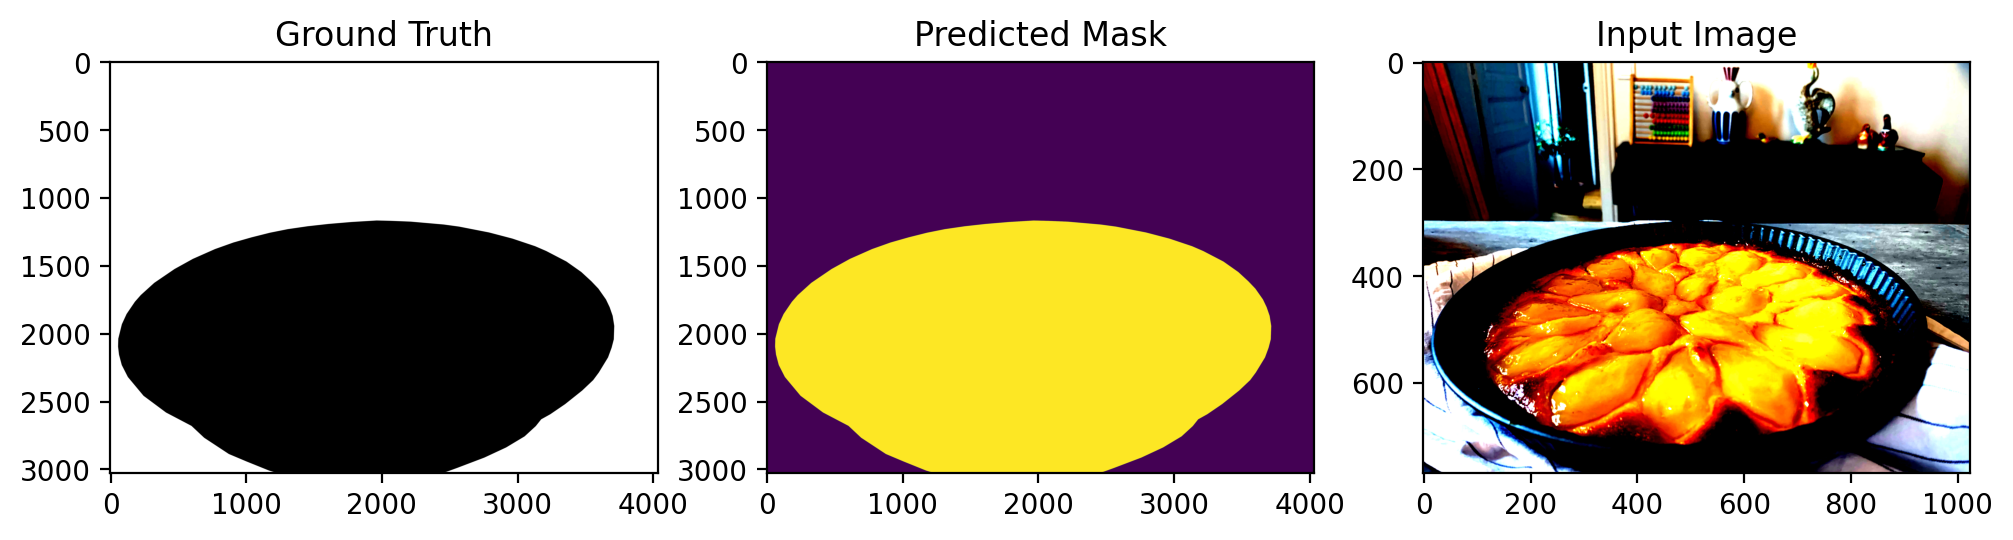

Processing images:  67%|██████▋   | 6/9 [00:49<00:27,  9.07s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 36])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 36])
feature fra siste lag: tensor([[[[-0.5867, -0.5089, -0.4450,  ..., -0.4087, -0.4273, -0.4325],
          [-0.6304, -0.5385, -0.5147,  ..., -0.2790, -0.4324, -0.4293],
          [-0.6095, -0.5859, -0.4480,  ..., -0.3093, -0.4876, -0.5204],
          ...,
          [ 0.0744,  0.1525,  0.1205,  ...,  0.0683, -0.0223,  0.0888],
          [ 0.1646,  0.2847,  0.1708,  ...,  0.0073,  0.0965, -0.2526],
          [-0.0477,  0.0940,  0.1175,  ...,  0.2119,  0.0706, -0.2243]],

         [[ 0.0881,  0.0513,  0.0521,  ..., -0.0420, -0.0910,  0.0365],
          [ 0.1981,  0.1609,  0.1831,  ..., -0.0706, -0.0385, -0.0232],
          [ 0.2532,  0.2378,  0.1969,  ...,  0.0039,  0.0643,  0.0310],
          ...,
          [-0.1212, -0.1674, -0.1734,  ..., -0.1204, -0.0722, -0.0651],
          [-0.0975, -0.1768, -0.1048,  ..., -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


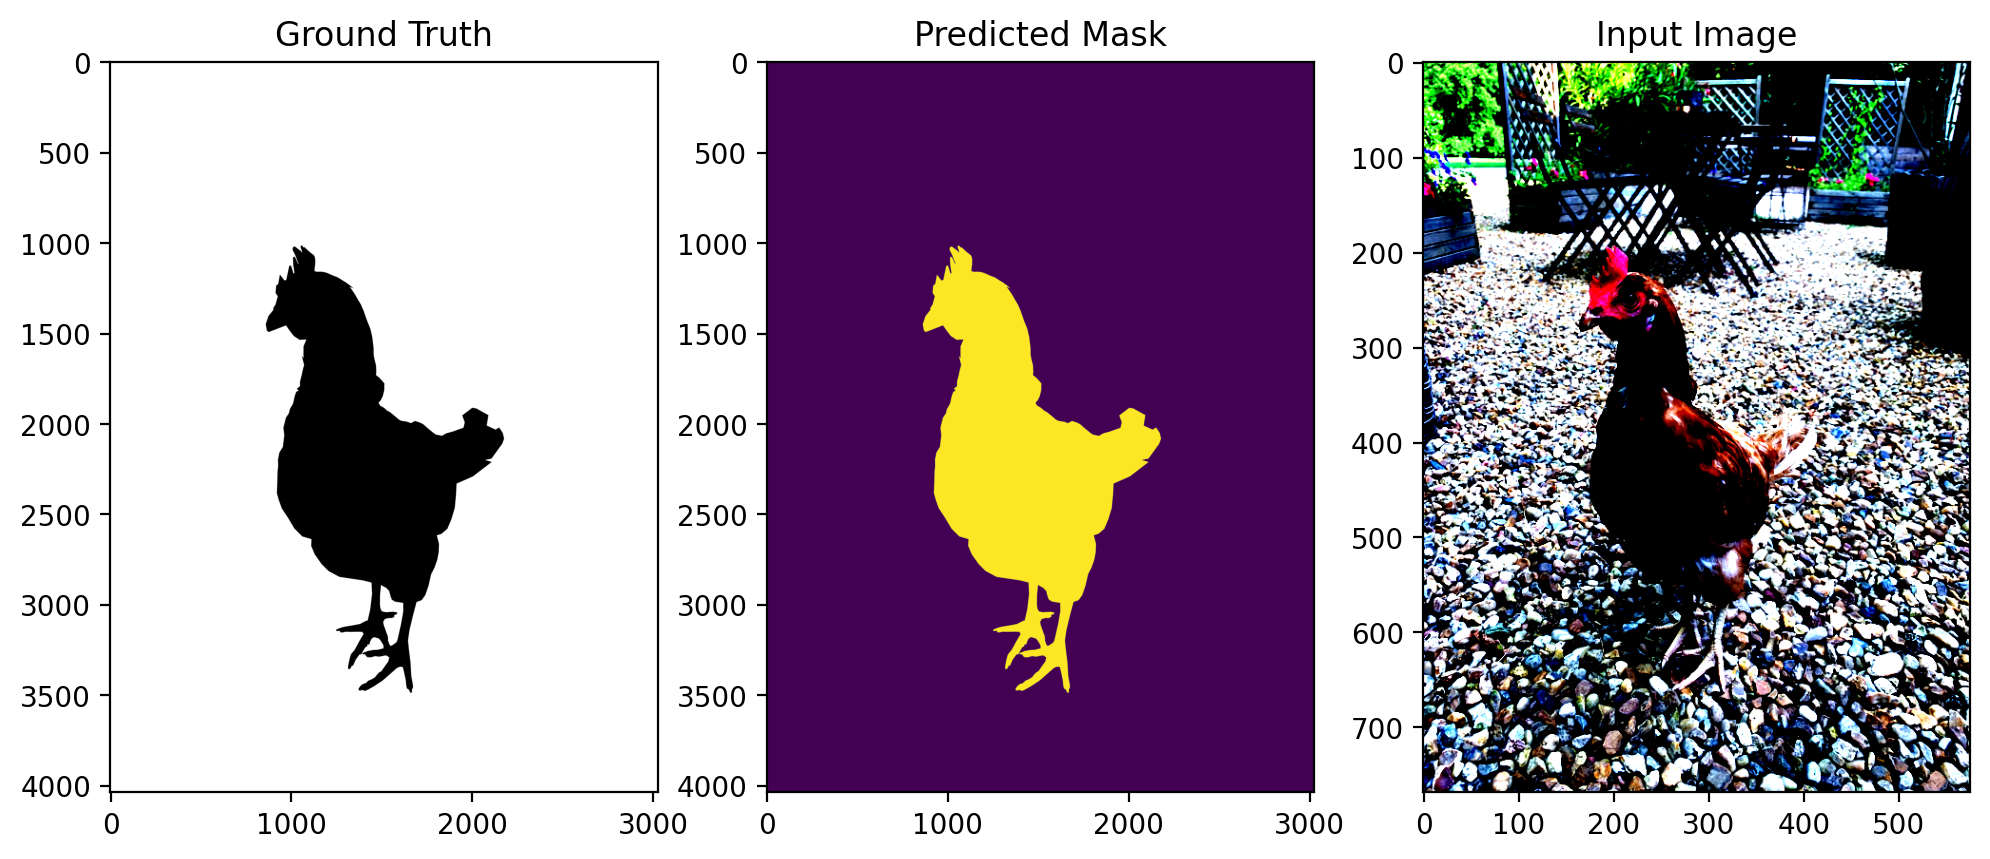

Processing images:  78%|███████▊  | 7/9 [00:59<00:18,  9.27s/it]

torch.Size([1728, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])
feature fra siste lag: tensor([[[[-0.3523, -0.3580, -0.4010,  ..., -0.5886, -0.6317, -0.6189],
          [-0.7381, -0.5398, -0.5580,  ..., -0.6358, -0.7036, -0.8502],
          [-0.8220, -0.7147, -0.7604,  ..., -0.8191, -0.8935, -0.9220],
          ...,
          [-0.4877, -0.4545, -0.3014,  ..., -0.3876, -0.4452, -0.5292],
          [-0.5201, -0.4774, -0.4001,  ..., -0.4163, -0.4116, -0.5090],
          [-0.1978, -0.4361, -0.3809,  ..., -0.4606, -0.4890, -0.5324]],

         [[-0.3772, -0.3526, -0.3627,  ...,  0.1222,  0.0914,  0.0888],
          [-0.2656, -0.2956, -0.3126,  ...,  0.0824,  0.0899,  0.1154],
          [-0.2149, -0.2738, -0.2516,  ...,  0.0960,  0.1011,  0.1707],
          ...,
          [ 0.2067,  0.1765,  0.1185,  ...,  0.1405,  0.1687,  0.1917],
          [ 0.1782,  0.1254,  0.0884,  ...,  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].


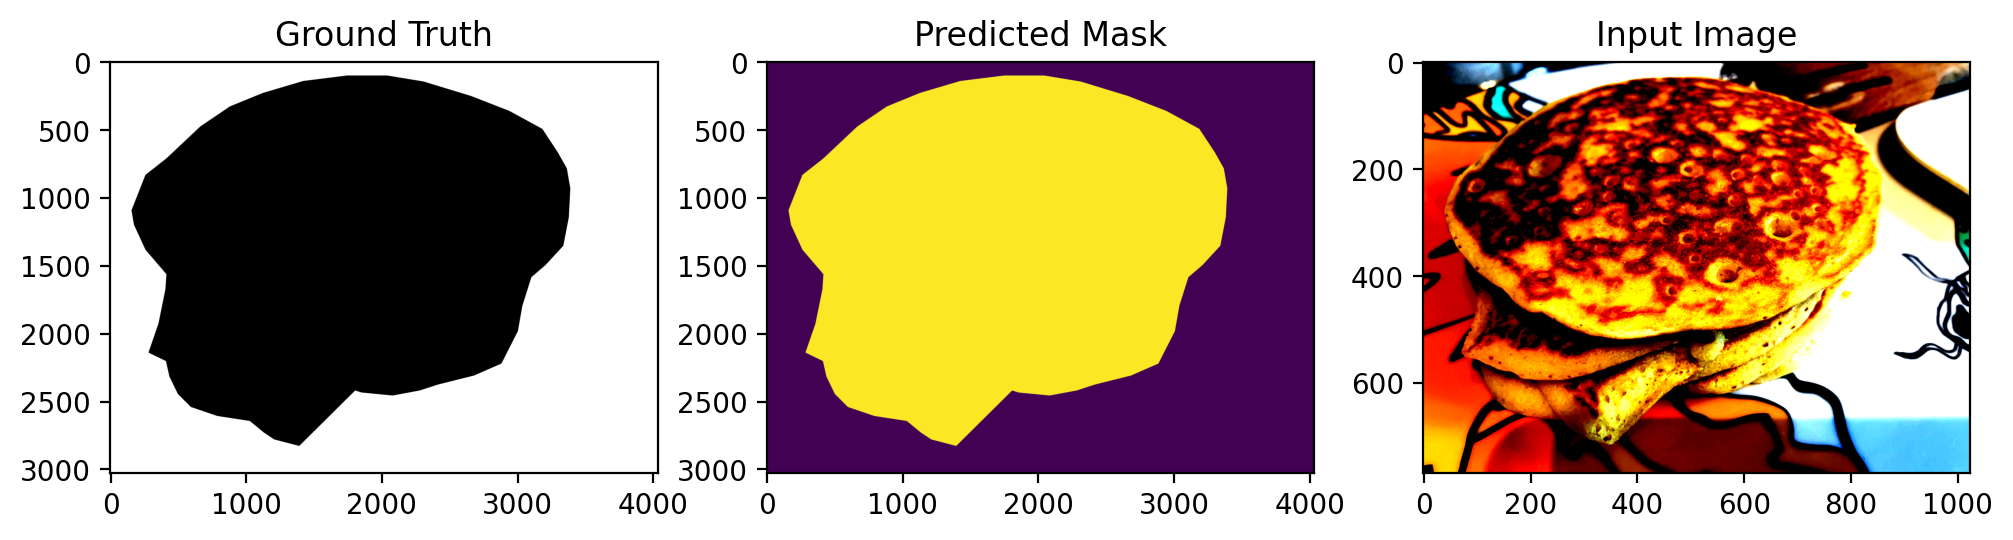

Processing images:  89%|████████▉ | 8/9 [01:07<00:08,  8.74s/it]

torch.Size([3072, 384])
Feature map shape: 12, type: <class 'tuple'>
Siste tensor shape: [torch.Size([1, 384, 48, 64])]
dim = 384
Feature map shape: torch.Size([1, 384, 48, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.4110641].


feature fra siste lag: tensor([[[[-6.1093e-01, -6.6271e-01, -5.8022e-01,  ..., -5.2022e-01,
           -5.8800e-01, -6.1417e-01],
          [-8.0717e-01, -6.6493e-01, -5.6993e-01,  ..., -5.2421e-01,
           -6.5995e-01, -6.7550e-01],
          [-8.0822e-01, -7.2307e-01, -5.9581e-01,  ..., -6.1597e-01,
           -6.5037e-01, -7.0451e-01],
          ...,
          [-3.8783e-01, -2.8504e-01, -2.5168e-01,  ..., -2.7491e-01,
           -2.9648e-01, -2.9923e-01],
          [-3.9426e-01, -3.2934e-01, -2.5650e-01,  ..., -3.7301e-01,
           -3.8215e-01, -3.5307e-01],
          [-3.7876e-01, -3.1982e-01, -2.6167e-01,  ..., -3.5847e-01,
           -4.1084e-01, -3.2444e-01]],

         [[ 1.6234e-01,  2.3315e-01,  2.4168e-01,  ...,  1.1642e-01,
            1.7162e-01,  2.0022e-01],
          [ 3.0849e-01,  2.9859e-01,  2.8954e-01,  ...,  1.1529e-01,
            1.6047e-01,  2.2892e-01],
          [ 3.3460e-01,  3.2741e-01,  3.0530e-01,  ...,  1.5773e-01,
            1.9712e-01,  2.2002e-01

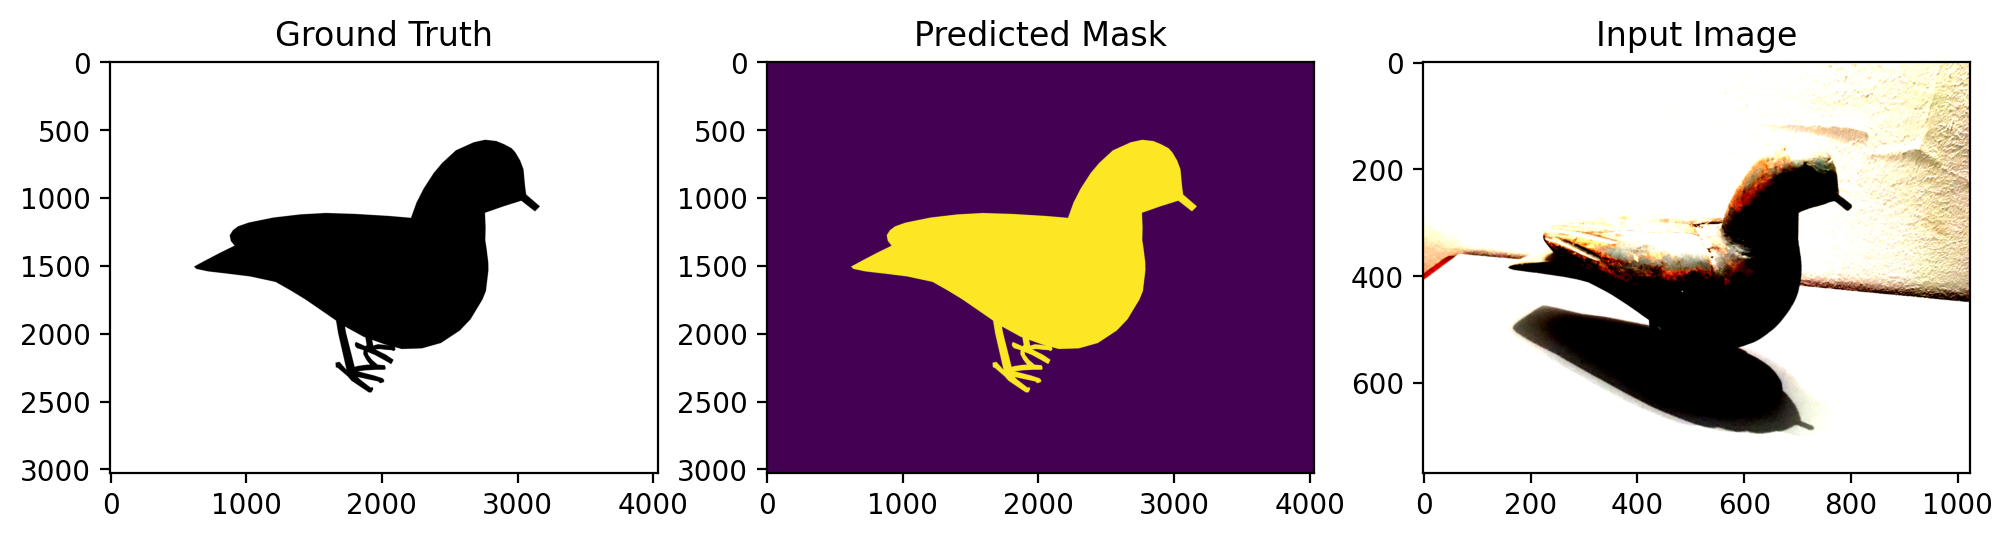

Processing images: 100%|██████████| 9/9 [01:14<00:00,  8.33s/it]

torch.Size([3072, 384])
Design matrix of size :  torch.Size([23604, 384])
Label matrix of size :  torch.Size([23604])


In [15]:
xs = []
ys = []
image_index = []

IMAGENET_MEAN = (0.485, 0.456, 0.406) # RGB mean for ImageNet
IMAGENET_STD = (0.229, 0.224, 0.225) # RGB std for ImageNet

# Self-attention lagene i DINOv3 ViT modellene
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# 
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Processing images"):

            # Loading the ground truth
            mask_i = labels[i].split()[-1]
            mask_i_resized = resize_transform(mask_i)
            mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
            ys.append(mask_i_quantized)
            
            # Loading the image data 
            image_i = images[i].convert('RGB')
            image_i_resized = resize_transform(image_i)
            image_i_resized = TF.normalize(image_i_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_i_resized = image_i_resized.unsqueeze(0).cuda()

            # tar ut features fra alle lag i modellen
            # feats blir en liste med feature tensorer fra hvert lag
            # Forklaring av tensor: 
            # en tensor er (N, D, H, W) der N=1 (batch size), D=dimensjon på features, H og W er romlige dimensjoner
            feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
            
            print(f"Feature map shape: {len(feats)}, type: {type(feats)}")
            print(f"Siste tensor shape: {[feats[-1].shape]}")

            # tar med features fra siste lag
            # Vi endrer formen på tensoren slik at vi får en rad per patch
            # feats[-1] er siste lag, som har formen (1, D, H, W)
            dim = feats[-1].shape[1]

            print(f"dim = {dim}")
            print(f"Feature map shape: {feats[0].shape}")
            print(f"feature fra siste lag: {feats[-1]}")

            xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

            image_index.append(i * torch.ones(ys[-1].shape))

             # Visualization of ground truth, predicted mask, input image
            plt.figure(figsize=(12, 6), dpi=200)
            plt.subplot(1, 3, 1)
            plt.imshow(labels[i])
            plt.title("Ground Truth")
            
            plt.subplot(1, 3, 2)
            plt.imshow(mask_i)
            plt.title("Predicted Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(image_i_resized.squeeze().permute(1,2,0).detach().cpu())
            plt.title("Input Image")
    
            plt.show()

            print(xs[i].shape)

# Concatenate all lists into torch tensors 
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# keeping only the patches that have clear positive or negative label
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size : ", xs.shape)
print("Label matrix of size : ", ys.shape)


### Training a Classifier and Model Selection
We computed the features, let's now train a classifier! Our data is very strongly correlated image-by-image. Therefore, to do proper model selection, we can't simply split the data in an IID way. We need to do something a bit smarter. We will do leave-one-out, and consecutively exclude each image as a validation set. 
We'll try 8 values of C ranging from 1e-7 to 1e-0. 

For each value of C and each image, we plot the precision-recall curve of the classifier, and report the mAP (area under the PR curve).

validation using image_01.jpg
training logisitic regression with C=1.00e-07


training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


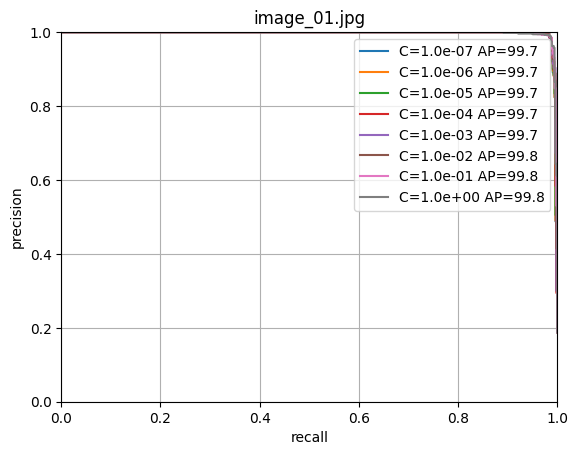

validation using image_02.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


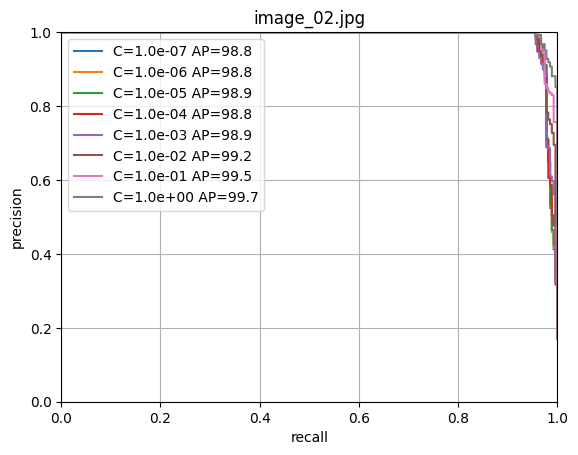

validation using image_03.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


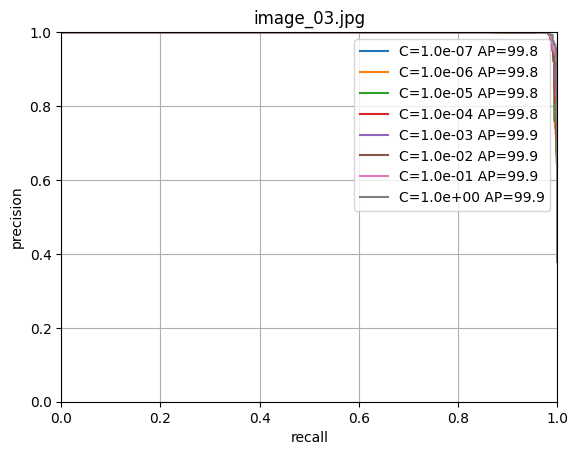

validation using image_04.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


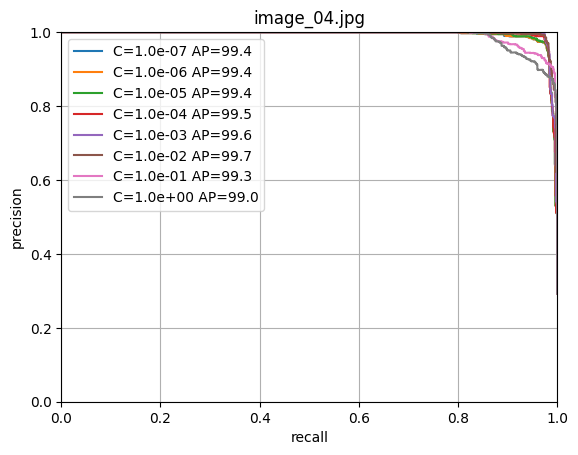

validation using image_05.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


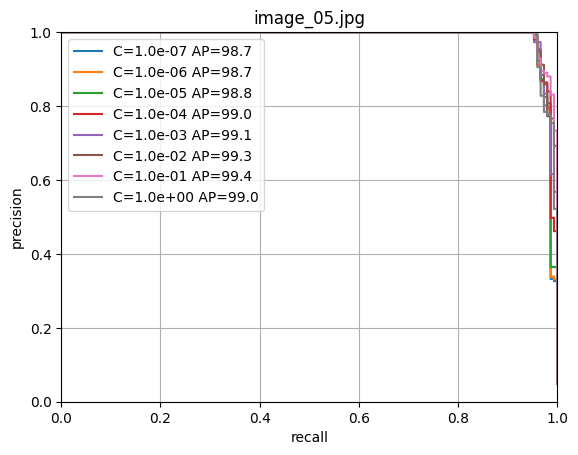

validation using image_06.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


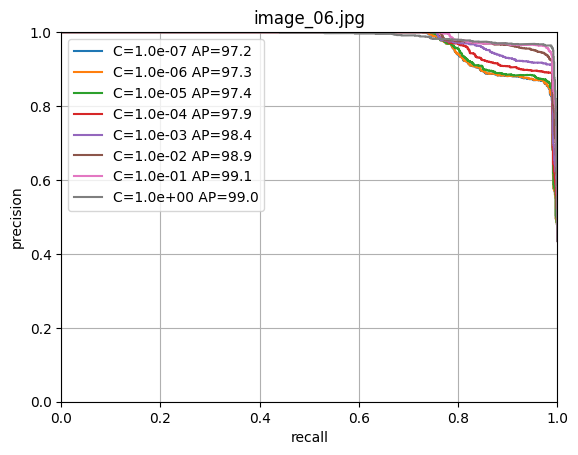

validation using image_07.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


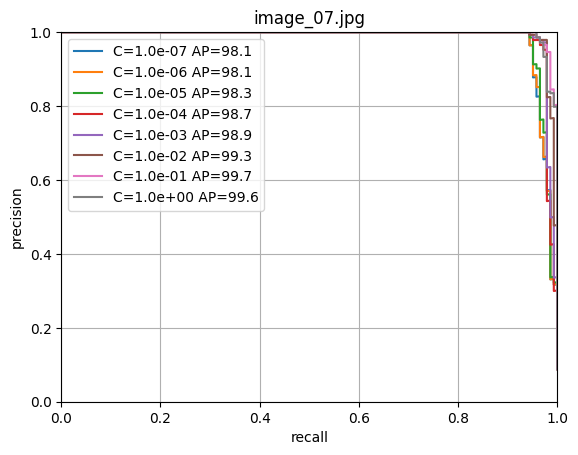

validation using image_08.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


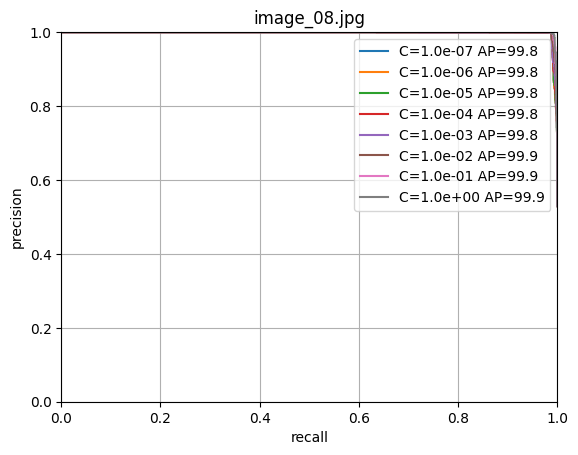

validation using image_09.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


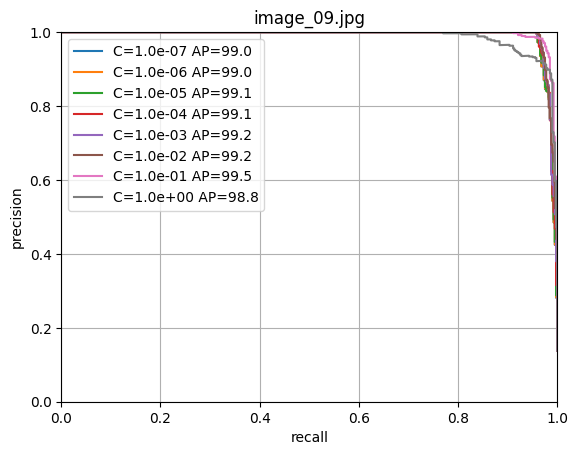

In [16]:
cs = np.logspace(-7, 0, 8)
scores = np.zeros((n_images, len(cs)))

for i in range(n_images):
    # We use leave-one-out so train will be all but image i, val will be image i
    print('validation using image_{:02d}.jpg'.format(i+1))
    train_selection = image_index != float(i)
    fold_x = xs[train_selection].numpy()
    fold_y = (ys[train_selection] > 0).long().numpy()
    val_x = xs[~train_selection].numpy()
    val_y = (ys[~train_selection] > 0).long().numpy()

    plt.figure()
    for j, c in enumerate(cs):
        print("training logisitic regression with C={:.2e}".format(c))
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x, fold_y)
        output = clf.predict_proba(val_x)
        precision, recall, thresholds = precision_recall_curve(val_y, output[:, 1])
        s = average_precision_score(val_y, output[:, 1])
        scores[i, j] = s
        plt.plot(recall, precision, label='C={:.1e} AP={:.1f}'.format(c, s*100))

    plt.grid()
    plt.xlabel('recall')
    plt.title('image_{:02d}.jpg'.format(i+1))
    plt.ylabel('precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.show()


### Choosing the Best C
Now, let's have a look at which value of C works best on average. To this end we will plot the average mAP across all validation images.

In [17]:
print(len(scores))
print(scores.shape)
print(scores)

print(np.max(scores, axis=1))

9
(9, 8)
[[0.99678385 0.99679195 0.99684609 0.99710948 0.9973607  0.99774444
  0.99801131 0.99771433]
 [0.98843204 0.98844306 0.98856725 0.98847725 0.98918292 0.99223877
  0.99488554 0.99719699]
 [0.99778936 0.99779475 0.99788958 0.99826734 0.99857864 0.99891831
  0.99924311 0.99940079]
 [0.99352136 0.99355669 0.99385301 0.99481842 0.99571872 0.9966056
  0.99263239 0.98996569]
 [0.9867806  0.98688588 0.98760272 0.98975213 0.99076005 0.99282645
  0.99427003 0.99043533]
 [0.97238562 0.97259598 0.97420623 0.97897293 0.98377964 0.98912778
  0.9912404  0.99030787]
 [0.98088367 0.98113393 0.98263694 0.98698975 0.98872392 0.99300317
  0.99663061 0.99555621]
 [0.99839162 0.99839214 0.99841525 0.9984961  0.99844894 0.998671
  0.99944593 0.9992973 ]
 [0.99035832 0.99037396 0.9905218  0.99105054 0.99154065 0.99248862
  0.99475645 0.98841045]]
[0.99801131 0.99719699 0.99940079 0.9966056  0.99427003 0.9912404
 0.99663061 0.99944593 0.99475645]


1.0


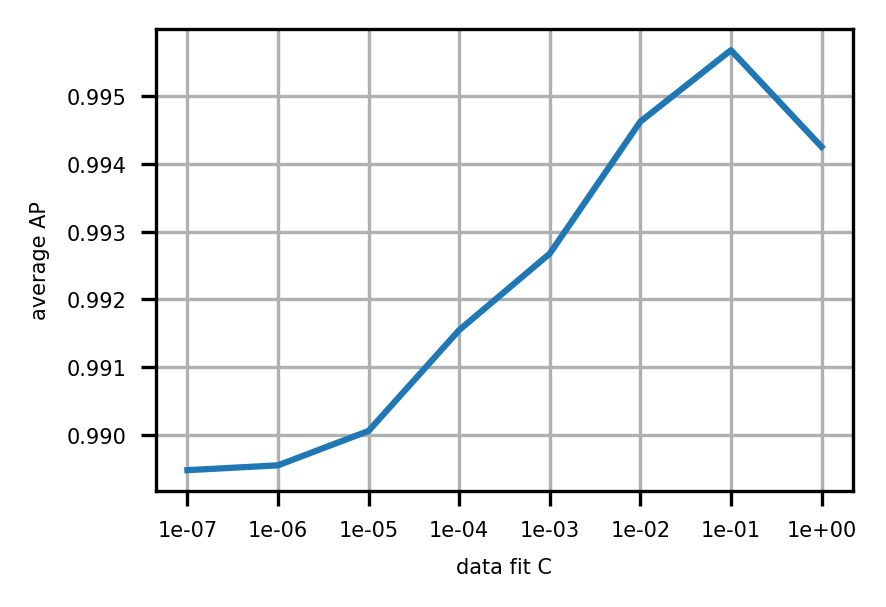

In [18]:
plt.figure(figsize=(3, 2), dpi=300)
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
})

print(c)
plt.plot(scores.mean(axis=0))
plt.xticks(np.arange(len(cs)), ["{:.0e}".format(c) for c in cs])
plt.xlabel('data fit C')
plt.ylabel('average AP')
plt.grid()
plt.show()

### Retraining with the optimal regularization
Given the above, we seem to have a winner: C=0.1. 
Let's now train a model using this optimal data-fit value. 

In [ ]:
print(xs.shape)
print(ys.shape)


In [19]:
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


### Test Images and Inference 

We have a classifier, now it is time to test it! We will predict the probability of patch being foreground given an image, and then process it with a 3x3 median filter to smooth it out.

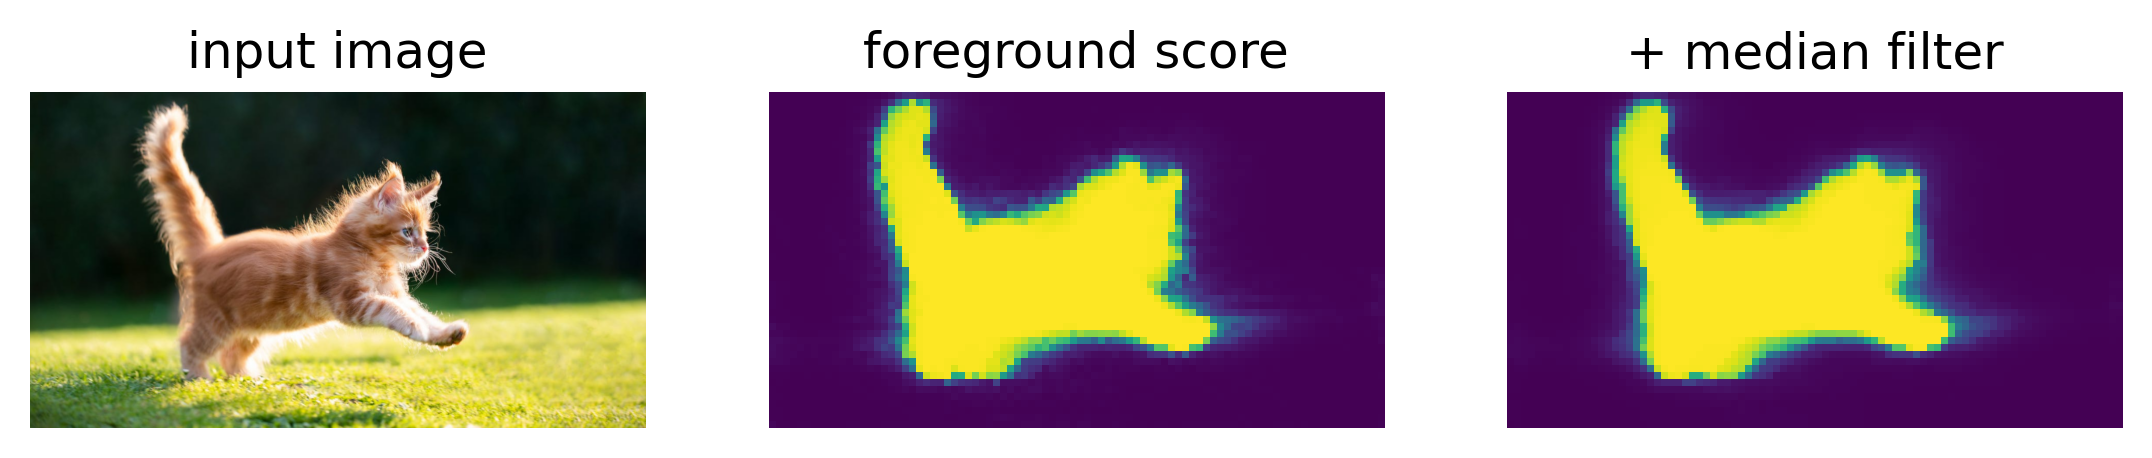

In [20]:
test_image_fpath = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/test_image.jpg"
test_image_fpath= "https://hips.hearstapps.com/hmg-prod/images/ginger-maine-coon-kitten-running-on-lawn-in-royalty-free-image-1719608142.jpg?crop=1xw:0.84415xh;0,0.185xh&resize=1200:*"
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


test_image = load_image_from_url(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.figure(figsize=(9, 3), dpi=300)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

In [21]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [22]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as TF
from scipy import signal
from PIL import Image

def show_video_with_foreground_mask(video_path, model, clf, resize_transform, 
                                   IMAGENET_MEAN, IMAGENET_STD, PATCH_SIZE, n_layers,
                                   apply_median_filter=True, show_original=True, 
                                   fps_limit=30, window_size=(1200, 600)):
    """
    Display video with real-time foreground segmentation overlay
    
    Args:
        video_path: Path to input video file
        model: DINOv3 model
        clf: Trained classifier
        resize_transform: Resize transform function
        IMAGENET_MEAN: ImageNet normalization mean
        IMAGENET_STD: ImageNet normalization std
        PATCH_SIZE: Patch size (16)
        n_layers: Number of layers in model
        apply_median_filter: Whether to apply median filter smoothing
        show_original: Whether to show original video alongside mask
        fps_limit: Maximum FPS for display
        window_size: (width, height) for display window
    
    Controls:
        - Press 'q' to quit
        - Press 'space' to pause/resume
        - Press 's' to save current frame
    """
    
    def process_frame_for_segmentation(frame):
        """Process a single frame and return foreground mask"""
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        
        # Preprocess
        frame_resized = resize_transform(frame_pil)
        frame_normalized = TF.normalize(frame_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        
        # Extract features
        with torch.inference_mode():
            with torch.autocast(device_type='cuda', dtype=torch.float32):
                feats = model.get_intermediate_layers(
                    frame_normalized.unsqueeze(0).cuda(), 
                    n=range(n_layers), 
                    reshape=True, 
                    norm=True
                )
                x = feats[-1].squeeze().detach().cpu()
                dim = x.shape[0]
                x = x.view(dim, -1).permute(1, 0)
        
        # Get foreground scores
        h_patches, w_patches = [int(d / PATCH_SIZE) for d in frame_resized.shape[1:]]
        fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
        
        # Apply median filter if requested
        if apply_median_filter:
            fg_score = signal.medfilt2d(fg_score, kernel_size=3)
        
        return fg_score, frame_resized
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Video: {total_frames} frames at {original_fps:.1f} FPS")
    print("Controls: 'q' to quit, 'space' to pause/resume, 's' to save frame")
    
    # Calculate frame delay for FPS limiting
    frame_delay = max(1, int(1000 / min(fps_limit, original_fps)))
    
    paused = False
    frame_count = 0
    
    while True:
        if not paused:
            ret, frame = cap.read()
            if not ret:
                print("End of video reached")
                break
            
            frame_count += 1
        
        try:
            # Process frame for segmentation
            fg_score, frame_resized = process_frame_for_segmentation(frame)
            
            # Convert tensors to numpy for display
            frame_np = (frame_resized.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            
            # Create colorized mask
            fg_score_norm = (fg_score * 255).astype(np.uint8)
            mask_colored = cv2.applyColorMap(fg_score_norm, cv2.COLORMAP_HOT)
            
            # Resize mask to match frame size
            frame_height, frame_width = frame_np.shape[:2]
            mask_resized = cv2.resize(mask_colored, (frame_width, frame_height))
            
            if show_original:
                # Show original and mask side by side
                frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
                combined = np.hstack([frame_bgr, mask_resized])
                
                # Add text overlay
                cv2.putText(combined, f"Frame: {frame_count}/{total_frames}", 
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(combined, "Original", (10, frame_height - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                cv2.putText(combined, "Foreground Mask", (frame_width + 10, frame_height - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                display_frame = combined
            else:
                # Show only the mask
                cv2.putText(mask_resized, f"Frame: {frame_count}/{total_frames}", 
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                display_frame = mask_resized
            
            # Resize for display if needed
            display_height, display_width = display_frame.shape[:2]
            if display_width > window_size[0] or display_height > window_size[1]:
                scale = min(window_size[0] / display_width, window_size[1] / display_height)
                new_width = int(display_width * scale)
                new_height = int(display_height * scale)
                display_frame = cv2.resize(display_frame, (new_width, new_height))
            
            # Show frame
            cv2.imshow('Foreground Segmentation', display_frame)
            
        except Exception as e:
            print(f"Error processing frame {frame_count}: {e}")
            continue
        
        # Handle keyboard input
        key = cv2.waitKey(frame_delay) & 0xFF
        
        if key == ord('q'):
            print("Quitting...")
            break
        elif key == ord(' '):  # Space bar
            paused = not paused
            print("Paused" if paused else "Resumed")
        elif key == ord('s'):  # Save frame
            filename = f"frame_{frame_count:06d}_segmentation.png"
            cv2.imwrite(filename, display_frame)
            print(f"Saved {filename}")
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("Video display ended")

# Usage example:
show_video_with_foreground_mask(
    "path/to/your/video.mp4",
    model, clf, resize_transform,
    IMAGENET_MEAN, IMAGENET_STD, PATCH_SIZE, n_layers
)

Error: Could not open video path/to/your/video.mp4


In [23]:

# Show only the mask
show_video_with_foreground_mask(
    "vecteezy_cat_1797950.mp4",
    model, clf, resize_transform,
    IMAGENET_MEAN, IMAGENET_STD, PATCH_SIZE, n_layers,
    show_original=False
)

Error: Could not open video vecteezy_cat_1797950.mp4


### Saving the Model for Future Use
We are nearly done, let's just save a pickle with the classifier.


In [24]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, "wb") as f:
  pickle.dump(clf, f)